<a href="https://colab.research.google.com/github/Adhvik09-oss/SnapCare/blob/main/SnapCareipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing out neccessary modules
import torch as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision
import torch
import torchvision.models as models
import torch.optim as optim


In [2]:
#writing our device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

### for more information on the different transfer learning architectures look at:
https://docs.pytorch.org/vision/0.9/models.html

In [3]:
resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
import torch.nn as nn
# we have to change the final layer because our dataset(SD-198) has 198 classes, unlike the standard 100 that resnet-50 comes with
resnet.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=198)

In [6]:
#freeze all the layers so we won't have to train it fully
for param in resnet.parameters():
  param.requires_grad = False

#unfreeze the fully connected layer
for param in resnet.fc.parameters():
  param.requires_grad = True

In [7]:
#selecting our loss function and optimizers
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = resnet.parameters(),
                            lr = 0.01,
                            momentum = 0.09)

In [8]:
#importing our dataset and preparing to create a dataloader
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import zipfile
import os

'''
We are using the dataset "SD-198" this dataset contains over 198 different skin diseases with over 6,000 images contatining images of
skin and respective disease, we downloaded the dataset from Kaggle at : https://www.kaggle.com/datasets/longngzzz/sd-198
'''

skin_data_path = '/content/drive/MyDrive/data.zip' #this is the google drive path of the dataset
extract_path = '/content/SD-198'  # Local Colab path to unzip

with zipfile.ZipFile(skin_data_path, 'r') as zip_ref: #this simply just extracts the zip file with data to a certain path
    zip_ref.extractall(extract_path)

In [10]:
import os
#double checking the strucure of our data

print(os.listdir(extract_path))  # Should list class folders
sample_class = os.listdir(extract_path)[0]
print("Sample images in class:", sample_class)
print(os.listdir(os.path.join(extract_path, sample_class))[:5])


['Digital_Fibroma', 'Morphea', 'Melasma', 'Tinea_Pedis', 'Pseudorhinophyma', 'Keratolysis_Exfoliativa_of_Wende', 'Actinic_solar_Damage(Cutis_Rhomboidalis_Nuchae)', 'Factitial_Dermatitis', 'Fixed_Drug_Eruption', 'Cutaneous_T-Cell_Lymphoma', 'Nail_Nevus', 'Lichen_Sclerosis_Et_Atrophicus', 'Steroid_Use_abusemisuse_Dermatitis', 'Syringoma', 'Follicular_Mucinosis', 'Scarring_Alopecia', 'Perioral_Dermatitis', 'Junction_Nevus', 'Stasis_Dermatitis', 'Milia', 'Schambergs_Disease', 'Mal_Perforans', 'Epidermal_Nevus', 'Beckers_Nevus', 'Stomatitis', 'Malignant_Melanoma', 'Guttate_Psoriasis', 'Cafe_Au_Lait_Macule', 'Lichen_Simplex_Chronicus', 'Nevus_Incipiens', 'Allergic_Contact_Dermatitis', 'Xerosis', 'Cellulitis', 'Cutis_Marmorata', 'Fibroma_Molle', 'Dermatosis_Papulosa_Nigra', 'Congenital_Nevus', 'Actinic_solar_Damage(Solar_Elastosis)', 'Neurotic_Excoriations', 'Nail_Psoriasis', 'Balanitis_Xerotica_Obliterans', 'Sebaceous_Gland_Hyperplasia', 'Androgenetic_Alopecia', 'Pearl_Penile_Papules', 'Gran

In [11]:
from torchvision import transforms
from torch.utils.data import DataLoader,random_split # import random split for later use
from torchvision.datasets import ImageFolder

train_data = transforms.Compose([
    transforms.Resize((224,224)), #resizes img to 224x224 which is what resnet uses
    transforms.ToTensor(), #transforms from PIL to Pytorch Tensor
    transforms.Normalize([0.485,0.456,0.406],
                          [0.229, 0.224, 0.225])

])

dataset = ImageFolder(root = extract_path, transform = train_data) # this is our data in the form of a Image Folder, we will have to change this into a

train_split = int(0.8*len(dataset))
testing_split = len(dataset)-train_split

train_dataset,test_dataset = random_split(dataset,[train_split,testing_split])

train_loader = DataLoader(train_dataset,batch_size = 32, shuffle = True,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size = 32, shuffle = False,drop_last=True)

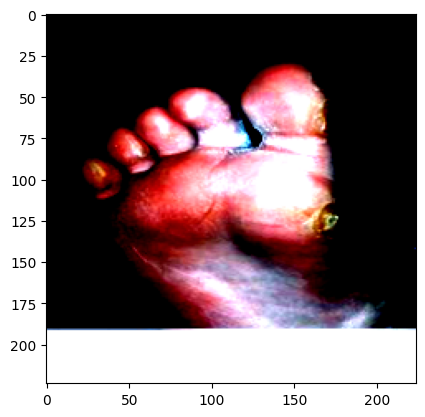

In [12]:
import matplotlib.pyplot as plt
data_iter = iter(train_loader)
images, labels = next(data_iter)
img = images[0].permute(1, 2, 0)
plt.imshow(img)

In [13]:
def accuracy_fn(true_values, prediction_values):
    correct = (true_values == prediction_values).sum()
    return correct.float() / true_values.size(0)  # a single scalar tensor


In [14]:
#importing a function previously made to measure the time
def print_train_time(start:float,
                     end:float,
                     device: torch.device = None):

  "print difference between start and end time"
  total_time = end-start
  print(f"train time on {device}: {total_time:.3f} seconds")

In [15]:
#making our training function

def training_steps(model: torch.nn.Module(),
                   loss_fn: torch.nn.Module(),
                   DataLoader: torch.utils.data.DataLoader,
                   optimizer : torch.optim.Optimizer,
                   accuracy,
                   device: torch.device = device
                   ):

  training_loss,training_accuracy = 0,0
  for batch, (X,y) in enumerate(tqdm(DataLoader)):
    # going throughout the batches
    X,y = X.to(device),y.to(device)


    #do the forward pass
    y_predictions = model(X)

    #calculate loss and do accuracy
    loss = loss_fn(y_predictions,y)
    training_loss +=loss #accumulating the loss so we can divde by total later

    training_accuracy += accuracy(true_values = y, prediction_values = y_predictions.argmax(dim=1)) # accumulating loss so we can divide by total later, using argmax so we can go from logits to actual predictions

    #optim zero grad
    optimizer.zero_grad()
    #backpropagation
    loss.backward()
    #optimizer step
    optimizer.step()
  true_train_loss = training_loss/len(DataLoader)
  true_train_acc = training_accuracy/len(DataLoader)
  print(f" The training loss is {true_train_loss}")
  print(f"the training accuracy is {true_train_acc}")


In [16]:
#making our testing function
def testing_step(model: torch.nn.Module(),
                   loss_fn: torch.nn.Module(),
                   DataLoader: torch.utils.data.DataLoader,
                   optimizer : torch.optim.Optimizer,
                   accuracy,
                   device: torch.device = device):
  testing_loss,testing_accuracy = 0,0

  model.eval()

  with torch.inference_mode():

    for X,y in DataLoader:
      X,y = X.to(device),y.to(device)

      #do the forward pass
      test_predictions = model(X)

      #test loss and test accuracy
      test_loss = loss_fn(test_predictions,y)
      testing_loss += test_loss

      testing_accuracy += accuracy(true_values = y, prediction_values = test_predictions.argmax(dim=1))
      #
    true_test_loss = testing_loss/len(DataLoader)
    true_test_accuracy = testing_accuracy/len(DataLoader)
    print(f"\n train loss: Test loss {true_test_loss}, test_acc {true_test_accuracy}")



In [19]:
#training our model
from tqdm.auto import tqdm
from timeit import default_timer as timer
epochs = 35

start_time = timer()

for i in tqdm(range(epochs)):
  print(f"Epoch: {i}")
  training_steps(model = resnet.to(device),
                 DataLoader = train_loader,
                 loss_fn = loss_fn,
                 accuracy  = accuracy_fn,
                 optimizer = optimizer,
                 device = device)
  testing_step(model = resnet.to(device),
                 DataLoader = test_loader,
                 loss_fn = loss_fn,
                 accuracy  = accuracy_fn,
                 optimizer = optimizer,
                 device = device)
end_time = timer()
total = print_train_time(start = start_time,
                         end = end_time,
                         device=str(next(resnet.parameters())))
print(f"Total train time = {total}")


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.4770570993423462
the training accuracy is 0.7280868887901306

 train loss: Test loss 2.714149236679077, test_acc 0.36814022064208984
Epoch: 1


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.4501084089279175
the training accuracy is 0.7341844439506531

 train loss: Test loss 2.7172415256500244, test_acc 0.3742378056049347
Epoch: 2


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.4219380617141724
the training accuracy is 0.7408536076545715

 train loss: Test loss 2.7097182273864746, test_acc 0.36051827669143677
Epoch: 3


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.398451566696167
the training accuracy is 0.7437118887901306

 train loss: Test loss 2.693209409713745, test_acc 0.36814022064208984
Epoch: 4


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.3728371858596802
the training accuracy is 0.7562881112098694

 train loss: Test loss 2.682553291320801, test_acc 0.36966460943222046
Epoch: 5


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.3504745960235596
the training accuracy is 0.7614328861236572

 train loss: Test loss 2.6726348400115967, test_acc 0.3643292486667633
Epoch: 6


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.3290412425994873
the training accuracy is 0.7646722197532654

 train loss: Test loss 2.669945001602173, test_acc 0.3719511926174164
Epoch: 7


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.3046566247940063
the training accuracy is 0.766196608543396

 train loss: Test loss 2.6659910678863525, test_acc 0.3620426654815674
Epoch: 8


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.2855534553527832
the training accuracy is 0.7738185524940491

 train loss: Test loss 2.654531478881836, test_acc 0.38185974955558777
Epoch: 9


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.2630943059921265
the training accuracy is 0.7820121645927429

 train loss: Test loss 2.6529743671417236, test_acc 0.3765243887901306
Epoch: 10


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.2424964904785156
the training accuracy is 0.7823932766914368

 train loss: Test loss 2.6360085010528564, test_acc 0.37804877758026123
Epoch: 11


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.2232829332351685
the training accuracy is 0.7917301654815674

 train loss: Test loss 2.636836290359497, test_acc 0.3711889982223511
Epoch: 12


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.208059310913086
the training accuracy is 0.7928734421730042

 train loss: Test loss 2.630204200744629, test_acc 0.38033536076545715
Epoch: 13


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.1862143278121948
the training accuracy is 0.8014481663703918

 train loss: Test loss 2.626615047454834, test_acc 0.3757621943950653
Epoch: 14


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.169183611869812
the training accuracy is 0.8062118887901306

 train loss: Test loss 2.615034341812134, test_acc 0.3856707215309143
Epoch: 15


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.151275634765625
the training accuracy is 0.8107850551605225

 train loss: Test loss 2.6151487827301025, test_acc 0.3856707215309143
Epoch: 16


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.1341005563735962
the training accuracy is 0.8140243887901306

 train loss: Test loss 2.6165857315063477, test_acc 0.38948169350624084
Epoch: 17


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.1181907653808594
the training accuracy is 0.8191691637039185

 train loss: Test loss 2.6154534816741943, test_acc 0.3826219439506531
Epoch: 18


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.1007479429244995
the training accuracy is 0.8241234421730042

 train loss: Test loss 2.6103806495666504, test_acc 0.384908527135849
Epoch: 19


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.0864611864089966
the training accuracy is 0.8254572749137878

 train loss: Test loss 2.5957283973693848, test_acc 0.3871951103210449
Epoch: 20


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.070863962173462
the training accuracy is 0.8304115533828735

 train loss: Test loss 2.597395658493042, test_acc 0.3871951103210449
Epoch: 21


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.056990385055542
the training accuracy is 0.8326981663703918

 train loss: Test loss 2.596956968307495, test_acc 0.384908527135849
Epoch: 22


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.0406867265701294
the training accuracy is 0.8378429412841797

 train loss: Test loss 2.5853769779205322, test_acc 0.39024388790130615
Epoch: 23


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.0240020751953125
the training accuracy is 0.840129554271698

 train loss: Test loss 2.585963487625122, test_acc 0.3841463327407837
Epoch: 24


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 1.0107200145721436
the training accuracy is 0.8458459973335266

 train loss: Test loss 2.5771000385284424, test_acc 0.3856707215309143
Epoch: 25


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.9996534585952759
the training accuracy is 0.8475609421730042

 train loss: Test loss 2.576401472091675, test_acc 0.3963414430618286
Epoch: 26


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.9858283400535583
the training accuracy is 0.8532773852348328

 train loss: Test loss 2.5745279788970947, test_acc 0.39176827669143677
Epoch: 27


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.9706051349639893
the training accuracy is 0.8523246645927429

 train loss: Test loss 2.5729076862335205, test_acc 0.38948169350624084
Epoch: 28


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.9583668112754822
the training accuracy is 0.8565167188644409

 train loss: Test loss 2.5714704990386963, test_acc 0.3856707215309143
Epoch: 29


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.9452065825462341
the training accuracy is 0.8601371645927429

 train loss: Test loss 2.571690797805786, test_acc 0.38871949911117554
Epoch: 30


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.9337454438209534
the training accuracy is 0.8629953861236572

 train loss: Test loss 2.5603976249694824, test_acc 0.394817054271698
Epoch: 31


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.9217435717582703
the training accuracy is 0.8666158318519592

 train loss: Test loss 2.561216354370117, test_acc 0.3833841383457184
Epoch: 32


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.9102663993835449
the training accuracy is 0.8694740533828735

 train loss: Test loss 2.5628225803375244, test_acc 0.394817054271698
Epoch: 33


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.9002516865730286
the training accuracy is 0.8725228309631348

 train loss: Test loss 2.554757595062256, test_acc 0.3955792486667633
Epoch: 34


  0%|          | 0/164 [00:00<?, ?it/s]

 The training loss is 0.8880347609519958
the training accuracy is 0.8749999403953552

 train loss: Test loss 2.545684576034546, test_acc 0.3925304710865021
train time on Parameter containing:
tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.79

In [21]:
#Saving the model
from pathlib import Path

MODEL_Path = Path('models')
MODEL_Path.mkdir(exist_ok=True,parents=True)

MODEL_DATA = "SKIN_MODEL"
MODEL_SAVING_PATH = MODEL_Path/MODEL_DATA

print(f"Saving to {MODEL_SAVING_PATH}")
torch.save(obj = resnet.state_dict(),
           f = MODEL_SAVING_PATH)

Saving to models/SKIN_MODEL
